In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
import torch.utils.data as Data 
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

import time
import random
import qrcode
from PIL import Image
import numpy as np

In [2]:
device = torch.device("cuda:3")

In [3]:
trainset = CIFAR10(
    root="./data/CIFAR10",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
)

testset = CIFAR10(
    root="./data/CIFAR10",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainloader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=256,
    shuffle=True,
)

testloader = torch.utils.data.DataLoader(
    dataset=testset,
    batch_size=256,
    shuffle=False
)

In [5]:
class EnDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            nn.GELU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(32, 2*32, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            nn.GELU(),
            nn.Conv2d(2*32, 2*32, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(2*32, 2*32, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            nn.GELU(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*32, 384) # 特征向量压缩到384维
        )
        
        self.linear = nn.Sequential(
            nn.Linear(384, 2*16*32),
            nn.GELU()
        )

        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(2*32, 2*32, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            nn.GELU(),
            nn.Conv2d(2*32, 2*32, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(2*32, 32, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            nn.GELU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.Encoder(x)
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.Decoder(x)
        return x

In [6]:
AE1 = torch.load("AEmodels/AE1.pt", map_location=device)
AE2 = torch.load("AEmodels/AE2.pt", map_location=device)
AE3 = torch.load("AEmodels/AE3.pt", map_location=device)
AE4 = torch.load("AEmodels/AE4.pt", map_location=device)
AE5 = torch.load("AEmodels/AE5.pt", map_location=device)

# 攻击者 AE = AE3
AE = AE3
for param in AE.parameters():
    param.requires_grad_(False)
AE.eval()

EnDecoder(
  (Encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU()
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1024, out_features=384, bias=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): GELU()
  )
  (Decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), 

In [7]:
def QR_gen(key):
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_Q,
        box_size=2,
        border=0,
    )
    qr.add_data(str(key))
    img = qr.make_image()
    img.save("./self/qrcode.png")

    Img = Image.open("./self/qrcode.png").convert('RGB')
    return Img

qr_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32)
])

In [8]:
# 生成个人信息：以key生成二维码
key = random.getrandbits(256)
qr_img = QR_gen(key)
qr_img = qr_transform(qr_img).to(torch.float)

In [9]:
w1 = torch.rand(3072)
w1 = w1.reshape(-1, 3, 32, 32) #与AE输入输出一致
w1 = w1.to(device)
w1.requires_grad_(True)

sig = qr_img.reshape(-1, 3, 32, 32) #所谓签名
sig = sig.to(device)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam([w1], lr=0.001)

p_num = 50 #carrier数
iter_num = 3000 #迭代轮数

In [10]:
for ii in range(iter_num):
    loss = 0
    start = time.process_time()
    
    for i in range(p_num):
        image = trainset[i][0].to(device) + w1
        image = image.reshape(-1, 3, 32, 32)
        op1 = AE1(image)
        op2 = AE2(image)
        #op3 = AE3(image)
        op4 = AE4(image)
        op5 = AE5(image)   
        
        loss = loss + loss_function(w1, op1)
        loss = loss + loss_function(w1, op2)
        loss = loss + loss_function(w1, op4)
        loss = loss + loss_function(w1, op5)

    optimizer.zero_grad()
    loss = loss + 0.02*torch.sum((w1-sig)**2)
    loss.backward()
    optimizer.step()
    
    if (ii%100)==0:
        print("iter: %i loss: %f" %(ii,loss/p_num))
        print("Elapsed time = %f" %(time.process_time()-start))
        start = time.process_time()

iter: 0 loss: 2.738142
Elapsed time = 0.945830
iter: 100 loss: 2.537069
Elapsed time = 0.628477
iter: 200 loss: 2.413009
Elapsed time = 0.572557
iter: 300 loss: 2.333030
Elapsed time = 0.517924
iter: 400 loss: 2.279571
Elapsed time = 0.521324
iter: 500 loss: 2.242855
Elapsed time = 0.527726
iter: 600 loss: 2.217162
Elapsed time = 0.535259
iter: 700 loss: 2.198976
Elapsed time = 0.552143
iter: 800 loss: 2.186035
Elapsed time = 0.527385
iter: 900 loss: 2.176830
Elapsed time = 0.520073
iter: 1000 loss: 2.170313
Elapsed time = 0.572909
iter: 1100 loss: 2.165739
Elapsed time = 0.526612
iter: 1200 loss: 2.162565
Elapsed time = 0.547546
iter: 1300 loss: 2.160390
Elapsed time = 0.547503
iter: 1400 loss: 2.158921
Elapsed time = 0.576926
iter: 1500 loss: 2.157939
Elapsed time = 0.595441
iter: 1600 loss: 2.157293
Elapsed time = 0.583155
iter: 1700 loss: 2.156873
Elapsed time = 0.531781
iter: 1800 loss: 2.156603
Elapsed time = 0.646948
iter: 1900 loss: 2.156431
Elapsed time = 0.652254
iter: 2000 l

In [11]:
def show_imgs(imgs):
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

def save_img(image, filename):
    img = image.reshape(3,32,32)
    img = img.detach().numpy()
    img = (img-np.min(img))/(np.max(img)-np.min(img))    #防止数值越界
    img = img.transpose((1,2,0))
    Image.fromarray(np.uint8(img*255)).convert('RGB').save(filename)

/home/zhuomengzhang/.conda/envs/torch/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


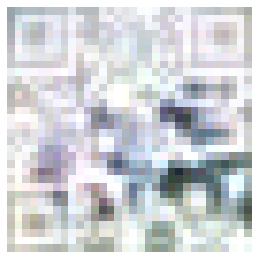

In [12]:
show_imgs(w1.cpu())
save_img(w1.cpu(), "w1.png")

In [16]:
def get_train_images(num):
    return torch.stack([trainset[i][0] for i in range(num)], dim=0)

input_imgs = get_train_images(p_num)   
w1_imgs = torch.cat([(image + w1.cpu()) for image in input_imgs], dim=0)  #w1carrier
AEw1_imgs = AE(w1_imgs.to(device)).cpu()  #经过AE攻击后

for i in range(p_num):
    save_img(w1_imgs[i], "./w1/o+/o+"+str(i)+".jpg")
    save_img(AEw1_imgs[i], "./w1/AE+/AE+"+str(i)+".jpg")

In [18]:
# cross
w3 = torch.zeros(3072)
w3 = w3.reshape(3, 32, 32)

def mark_cross(img, l=16):
    for i in range(l):
        img[0][i][i] = 1
        img[0][i][l-1-i] = 1
        img[1][i][i] = 1
        img[1][i][l-1-i] = 1
        img[2][i][i] = 1
        img[2][i][l-1-i] = 1
    return img

w3 = mark_cross(w3)
  
w3_imgs = torch.stack([(image + w3) for image in input_imgs], dim=0)  #w3carrier
AEw3_imgs = AE(w3_imgs.to(device)).cpu()  #经过AE攻击后

for i in range(p_num):
    save_img(w3_imgs[i], "./w3/o+/o+"+str(i)+".jpg")
    save_img(AEw3_imgs[i], "./w3/AE+/AE+"+str(i)+".jpg")